In [ ]:
%load_ext autoreload
%autoreload 2

# Parameter Sensitivity Analyses

This notebook demonstrates how to systematically shift one or more parameters in a memory search model according to a range of values of step size, and then with each configuration simulate the model and run analyses on the newly simulated data. We use the Healey & Kahana (2014) dataset as an example.

 **Outline**:
 1. **Parameter Setup**: Define the parameter bounds and the parameter(s) to shift.
 2. **Data & Model Loading**: Load the dataset, filter trials, import the model factory.
 3. **Simulating**: Use our custom function to re-simulate data for each parameter value.
 4. **Analyzing**: Plot various measures (SPC, CRP, PNR) for each shifted-parameter dataset.
 5. **Saving**: Save the output figures to a specified directory.

 ## 1. Parameter Setup

 Here, we specify which parameter(s) to vary, their numerical range, the run tag
 (for naming outputs), and other configuration details.

In [ ]:
# params for this run
run_tag = "Parameter_Shifting"

# model params
model_name = "BaseCMR"
model_factory_path = "jaxcmr.models.weird_cmr.BaseCMRFactory"
fit_result_path = (
    "fits/HealeyKahana2014_BaseCMR_best_of_3.json"
)

# data params: which data to use?
data_name = "HealeyKahana2014"
data_query = "data['listtype'] == -1"
data_path = "data/HealeyKahana2014.h5"
target_directory = "figures/shifting/"
connection_path = "data/peers-all-mpnet-base-v2.npy"

# simulation params
experiment_count = 50

# analysis params: which analyses to run?
analysis_paths = [
    "jaxcmr.analyses.spc.plot_spc",
    "jaxcmr.analyses.crp.plot_crp",
    "jaxcmr.analyses.pnr.plot_pnr",
]

# Parameter bounds (example)
bounds = {
    "encoding_drift_rate": [2.220446049250313e-16, 0.9999999999999998],
    "start_drift_rate":    [2.220446049250313e-16, 0.9999999999999998],
    "recall_drift_rate":   [2.220446049250313e-16, 0.9999999999999998],
    "shared_support":      [2.220446049250313e-16, 99.9999999999999998],
    "item_support":        [2.220446049250313e-16, 9.9999999999999998],
    "learning_rate":       [2.220446049250313e-16, 0.9999999999999998],
    "primacy_scale":       [2.220446049250313e-16, 99.9999999999999998],
    "primacy_decay":       [2.220446049250313e-16, 99.9999999999999998],
    "stop_probability_scale":  [2.220446049250313e-16, 0.9999999999999998],
    "stop_probability_growth": [2.220446049250313e-16, 9.9999999999999998],
    "choice_sensitivity":  [2.220446049250313e-16, 99.9999999999999998],
    # etc.
}

## 2. Data & Model Loading

 Next, we load the original HDF5 dataset, create a trial mask for the subset
 of trials we want to analyze, and load our pre-fit parameters. We also import
 the model factory and any analysis functions we need.

In [ ]:
from jaxcmr.helpers import generate_trial_mask, load_data, import_from_string, format_floats, find_project_root
import os
import json
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from jaxcmr.simulation import parameter_shifted_simulate_h5_from_h5
from jax import random
from matplotlib import rcParams  # type: ignore
from tqdm import tqdm

# Load the main dataset
data = load_data(os.path.join(find_project_root(), data_path))

# Create a mask selecting the trials we want
trial_mask = generate_trial_mask(data, data_query)

# Dynamically import the model factory class
model_factory = import_from_string(model_factory_path)

# Dynamically import each analysis function
analyses = [import_from_string(path) for path in analysis_paths]


# Optionally load a connectivity matrix (e.g., semantic similarity)
# For demonstration, we set up zeros if we don't want to use it
max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

# If you wanted embeddings, you'd do something like:
# embeddings = np.load(connection_path)
# connections = compute_similarity_matrix(embeddings)

# Load pre-fit parameters
with open(os.path.join(find_project_root(), fit_result_path), "r") as f:
    fit_result = json.load(f)
    # Some fit files might not contain a 'subject' field
    if "subject" not in fit_result["fits"]:
        fit_result["fits"]["subject"] = fit_result["subject"]

# Create output directory if it doesn't exist
if not os.path.exists(target_directory):
    os.makedirs(target_directory)

## 3. Simulation & Plotting Loop

Here, we iterate over each parameter in `bounds`. For each parameter we:

- Create a discretized set of values.
- Simulate new datasets using the function `parameter_shifted_simulate_h5_from_h5`.
- Immediately process these simulations using our analysis functions.
- Save and display the generated figures.

By processing each parameter in turn, we avoid holding all simulation results in memory.

  0%|          | 0/11 [00:00<?, ?it/s]

Saving figure: figures/shifting/BaseCMR_Encoding_Drift_Rate_Parameter_Shifting_spc_HealeyKahana2014.tif


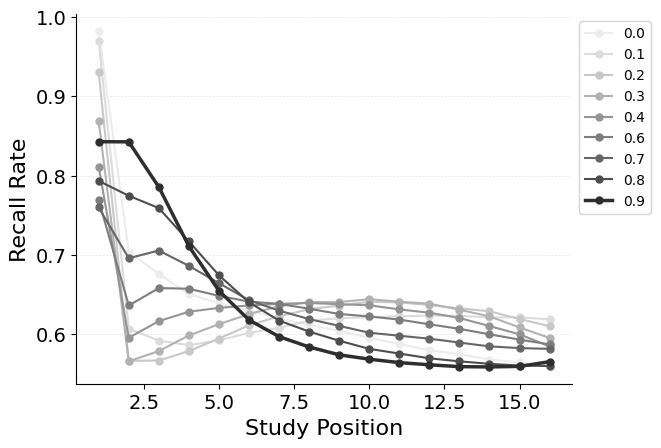

Saving figure: figures/shifting/BaseCMR_Encoding_Drift_Rate_Parameter_Shifting_crp_HealeyKahana2014.tif


  0%|          | 0/11 [01:10<?, ?it/s]


KeyboardInterrupt: 

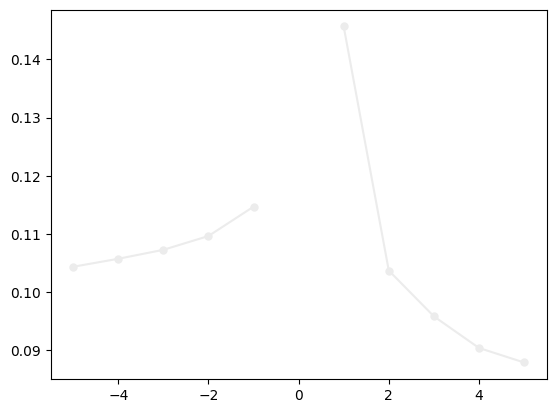

In [ ]:
#|notest

rng = random.PRNGKey(0)

for shifted_parameter, (min_value, max_value) in tqdm(bounds.items()):

    # Define the number of parameter values using the available palette length
    color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]
    considered_values = jnp.linspace(
        start=min_value,
        stop=max_value,
        num=len(color_cycle)
    )[:-1].tolist()  # Remove the last value for consistency

    # Simulate data for each of those parameter values
    rng, rng_iter = random.split(rng)
    sim = parameter_shifted_simulate_h5_from_h5(
        model_factory,
        data,
        connections,
        {key: jnp.array(val) for key, val in fit_result["fits"].items()},
        trial_mask,
        experiment_count,
        shifted_parameter,
        considered_values,
        rng_iter,
    )

    # Convert each dataset to a numba-friendly dictionary if needed
    # sim = [
    #     to_numba_typed_dict({key: np.array(val) for key, val in each.items()})
    #     for each in sim
    # ]

    # (Optional) Reset subjects for uniformity
    for i in range(len(sim)):
        sim[i]["subject"] *= 0

    # Create a common trial mask from the simulated data
    _trial_mask = generate_trial_mask(sim[0], data_query)

    # Loop through each analysis function
    for analysis in analyses:
        figure_str = (
            f"{model_name}_{shifted_parameter.title()}_{run_tag}_"
            f"{analysis.__name__[5:]}_{data_name}.tif"
        )
        print(f"Maybe saving figure: {target_directory}{figure_str}")

 # -------------- A.  COLOURED VERSION (existing behaviour) --------------
        # # Create a color cycle using a continuous colormap
        # cmap = plt.get_cmap("viridis")
        # color_cycle = [cmap(i) for i in np.linspace(0, 1, len(considered_values))]
        # color_cycle = [mcolors.rgb2hex(c) for c in color_cycle]

        # # Run the analysis function on the simulated datasets
        # axis = analysis(
        #     datasets=sim,
        #     trial_masks=[_trial_mask] * len(considered_values),
        #     color_cycle=color_cycle,
        #     distances=1 - connections,  # optional; adjust as needed
        #     axis=plt.gca(),
        #     labels=format_floats(considered_values, 1),
        #     contrast_name=shifted_parameter,
        #     # handle_repetitions=handle_repetitions[i],
        # )

        # # Format the plot (font sizes, legend location, etc.)
        # axis.tick_params(labelsize=14)
        # axis.set_xlabel(axis.get_xlabel(), fontsize=16)
        # axis.set_ylabel(axis.get_ylabel(), fontsize=16)
        # axis.legend(loc="upper left", bbox_to_anchor=(1, 1))

        # coloured_path = f"{target_directory}{figure_str}"
        # plt.savefig(coloured_path, bbox_inches="tight", dpi=600)
        # plt.show()
        
        # -------------- B.  GREY‑SCALE GRADIENT VERSION ------------------------
                # Create a color cycle using a continuous colormap
        cmap = plt.get_cmap("Greys")
        n_vals      = len(considered_values)
        eps         = 0.15                      # how far to stay away from pure white
        color_cycle = [cmap(x) for x in np.linspace(eps, 1 - eps, n_vals)]
        color_cycle = [mcolors.rgb2hex(c) for c in color_cycle]
        
        # Run the analysis function on the simulated datasets
        axis = analysis(
            datasets=sim,
            trial_masks=[_trial_mask] * len(considered_values),
            color_cycle=color_cycle,
            distances=1 - connections,  # optional; adjust as needed
            axis=plt.gca(),
            labels=format_floats(considered_values, 1),
            contrast_name=shifted_parameter,
            # handle_repetitions=handle_repetitions[i],
        )
        axis.get_lines()[-1].set_linewidth(2.5)   # thicken the lightest line

        # Format the plot (font sizes, legend location, etc.)
        axis.tick_params(labelsize=14)
        axis.set_xlabel(axis.get_xlabel(), fontsize=16)
        axis.set_ylabel(axis.get_ylabel(), fontsize=16)
        axis.legend(loc="upper left", bbox_to_anchor=(1, 1))

        # bw_path = f"{target_directory}bw_{figure_str}"
        # plt.savefig(bw_path, bbox_inches="tight", dpi=600)
        plt.show()
